In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
from omegaconf import OmegaConf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py

from cmass.utils import get_source_path, cosmo_to_astropy

In [2]:
wdir = '/automnt/data80/mattho/cmass-ili'

## Load and plot what we have

In [3]:
# Test suite
suite = 'mtng'
sim = 'nbody'
L, N = 3000, 384

source_path = get_source_path(wdir, suite, sim, L, N, 0)

cfg = OmegaConf.load(join(source_path, 'config.yaml'))
# print(OmegaConf.to_yaml(cfg))
cosmo = cfg.nbody.cosmo
cosmo_astropy = cosmo_to_astropy(params=cosmo)

In [4]:
gpos = np.load(join(source_path, 'halo_pos.npy'))
gvel = np.load(join(source_path, 'halo_vel.npy'))

gmeta = {
    'halo_mass': np.load(join(source_path, 'halo_mass.npy')),
    'mag': np.load(join(source_path, 'galaxy_mag.npy')),
    'magdust': np.load(join(source_path, 'galaxy_magdust.npy')),
    'obsmag': np.load(join(source_path, 'galaxy_obsmag.npy')),
    'obsmagdust': np.load(join(source_path, 'galaxy_obsmagdust.npy')),
    'stellarmass': np.load(join(source_path, 'galaxy_stellarmass.npy')),
}

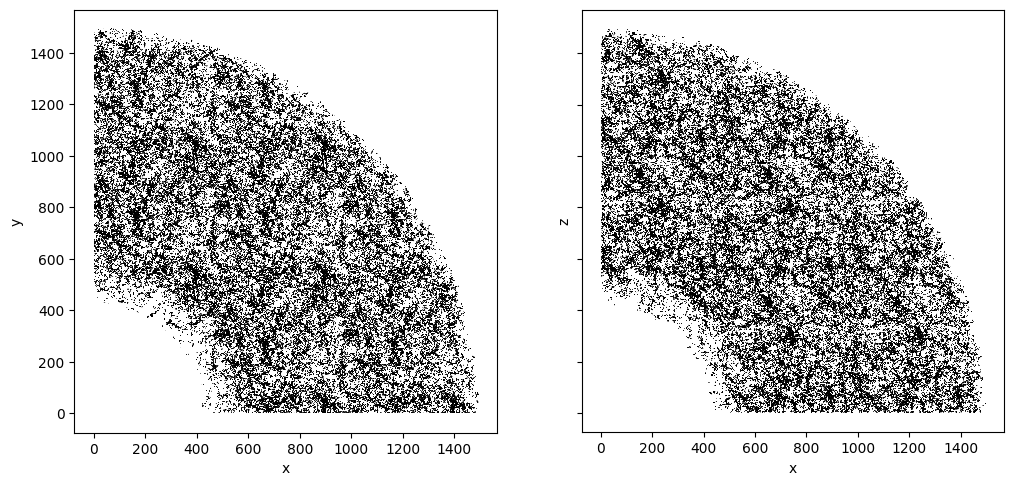

In [5]:
def mask_slice(pos, xmin, xmax, axis=0):
    return (pos[:, axis] >= xmin) & (pos[:, axis] < xmax)

f, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
mask = mask_slice(gpos, 900, 1000, 2)
axs[0].plot(gpos[mask, 0], gpos[mask, 1], 'k,', alpha=0.1)
axs[0].set(xlabel='x', ylabel='y', aspect='equal')

mask = mask_slice(gpos, 900, 1000, 1)
axs[1].plot(gpos[mask,0], gpos[mask,2], 'k,', alpha=0.1)
axs[1].set(xlabel='x', ylabel='z', aspect='equal');

In [6]:
from cmass.survey.tools import xyz_to_sky

grdz = xyz_to_sky(pos=gpos, vel=gvel, cosmo=cosmo)

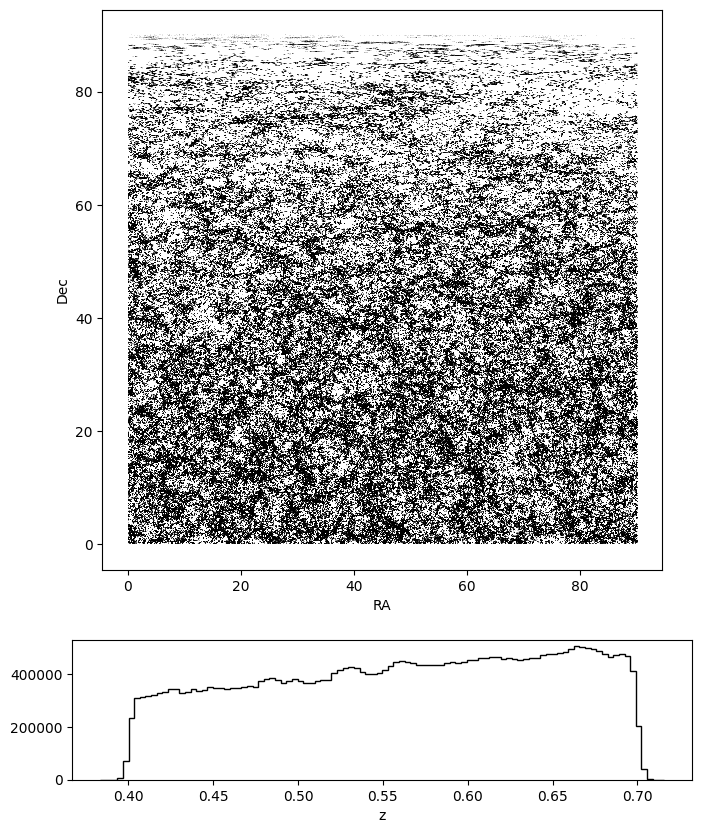

In [7]:
f, axs = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [4, 1]})

mask = mask_slice(grdz, 0.5, 0.55, 2)
axs[0].plot(grdz[mask,0], grdz[mask,1], 'k,', alpha=0.1)
axs[0].set(xlabel='RA', ylabel='Dec', aspect='equal')

axs[1].hist(grdz[:,2], bins=100, histtype='step', color='k')
axs[1].set(xlabel='z');

MTNG lightcone is distributed from (0,90) in the first octant

## Compare to real observations

In [8]:
# load real observations
cmass_file = join(wdir, 'cmass_ngc', 'cmass', 'L0-N0', '0', 'lightcone', 'hod000_aug000.h5')
with h5py.File(cmass_file, 'r') as f:
    ordz = np.stack([
        f['ra'][...],
        f['dec'][...],
        f['z'][...]
    ], axis=1)

from cmass.survey.tools import sky_to_xyz
oxyz = sky_to_xyz(ordz, cosmo=cosmo)

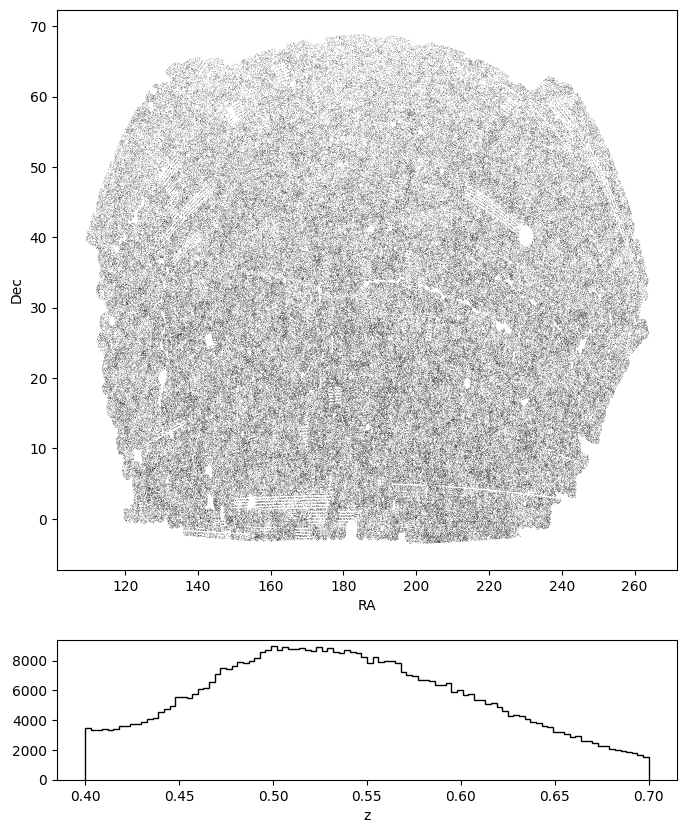

In [9]:
f, axs = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [4, 1]})
axs[0].plot(ordz[:,0], ordz[:,1], 'k,', alpha=0.1)
axs[0].set(xlabel='RA', ylabel='Dec')

axs[1].hist(ordz[:,2], bins=100, histtype='step', color='k')
axs[1].set(xlabel='z');

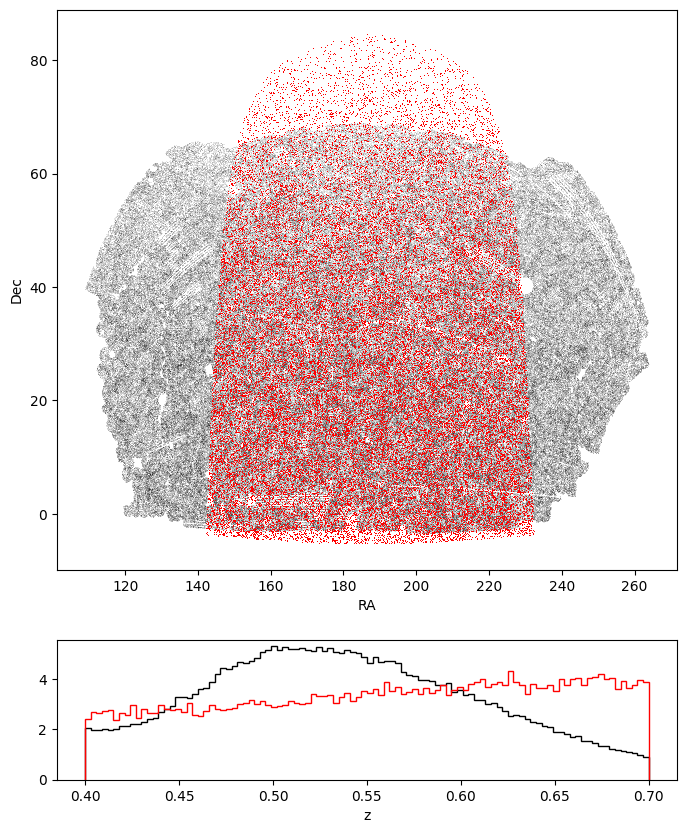

In [18]:
# Find a rotation scheme that aligns the two distributions
from scipy.spatial.transform import Rotation

rxyz = gpos[::1000]

# Rotate -dec
ang = -0.03*np.pi
Rz = Rotation.from_rotvec(
    np.array([1, -1, 0])/np.sqrt(2)*ang)
rxyz = Rz.apply(rxyz)

# Rotate +ra
ang = np.pi*0.79
Rr = Rotation.from_rotvec([0,0,ang])
rxyz = Rr.apply(rxyz)

# Convert to sky coordinates
rrdz = xyz_to_sky(rxyz, vel=None, cosmo=cosmo)

f, axs = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [4, 1]})
axs[0].plot(ordz[:,0], ordz[:,1], 'k,', alpha=0.1)
axs[0].plot(rrdz[:,0], rrdz[:,1], 'r,', alpha=1)
axs[0].set(xlabel='RA', ylabel='Dec')

axs[1].hist(ordz[:,2], bins=100, histtype='step', color='k', density=True)
axs[1].hist(rrdz[:,2], bins=100, histtype='step', color='r', density=True)
axs[1].set(xlabel='z');

## Develop a scheme to match cuts

In [19]:
# Cut observational data in the reference frame of the first octant

# Rotate to first octant
ioxyz = Rr.inv().apply(oxyz)
ioxyz = Rz.inv().apply(ioxyz)

# Apply cuts
iordz = xyz_to_sky(ioxyz, vel=None, cosmo=cosmo)
mask = (0 < iordz[:,0]) & (iordz[:,0] <90)
mask &= (0 < iordz[:,1]) & (iordz[:,1] <90)
ioxyz = ioxyz[mask]

# Rotate back
iioxyz = Rz.apply(ioxyz)
iioxyz = Rr.apply(iioxyz)
iiordz = xyz_to_sky(iioxyz, vel=None, cosmo=cosmo)

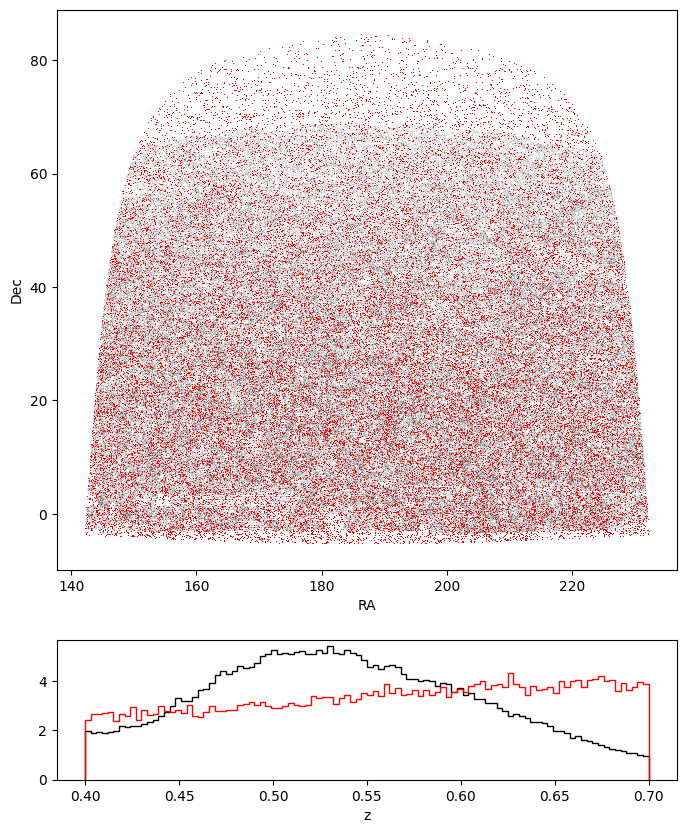

In [20]:
f, axs = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [4, 1]})
axs[0].plot(iiordz[:,0], iiordz[:,1], 'k,', alpha=0.1)
axs[0].plot(rrdz[:,0], rrdz[:,1], 'r,', alpha=1)
axs[0].set(xlabel='RA', ylabel='Dec')

axs[1].hist(iiordz[:,2], bins=100, histtype='step', color='k', density=True)
axs[1].hist(rrdz[:,2], bins=100, histtype='step', color='r', density=True)
axs[1].set(xlabel='z');

In [21]:
# Apply survey masks to MTNG data

from cmass.survey.tools import BOSS_angular, BOSS_veto, BOSS_redshift

mask = BOSS_angular(ra=rrdz[:,0], dec=rrdz[:,1], wdir=wdir)
mrrdz = rrdz[mask]
mask = BOSS_veto(ra=mrrdz[:,0], dec=mrrdz[:,1], verbose=True, wdir=wdir)
mrrdz = mrrdz[~mask]
mask = BOSS_redshift(z=mrrdz[:,2])
mrrdz = mrrdz[mask]

badfield_mask_postprocess_pixs8.ply
badfield_mask_unphot_seeing_extinction_pixs8_dr12.ply
allsky_bright_star_mask_pix.ply
bright_object_mask_rykoff_pix.ply
centerpost_mask_dr12.ply
collision_priority_mask_dr12.ply


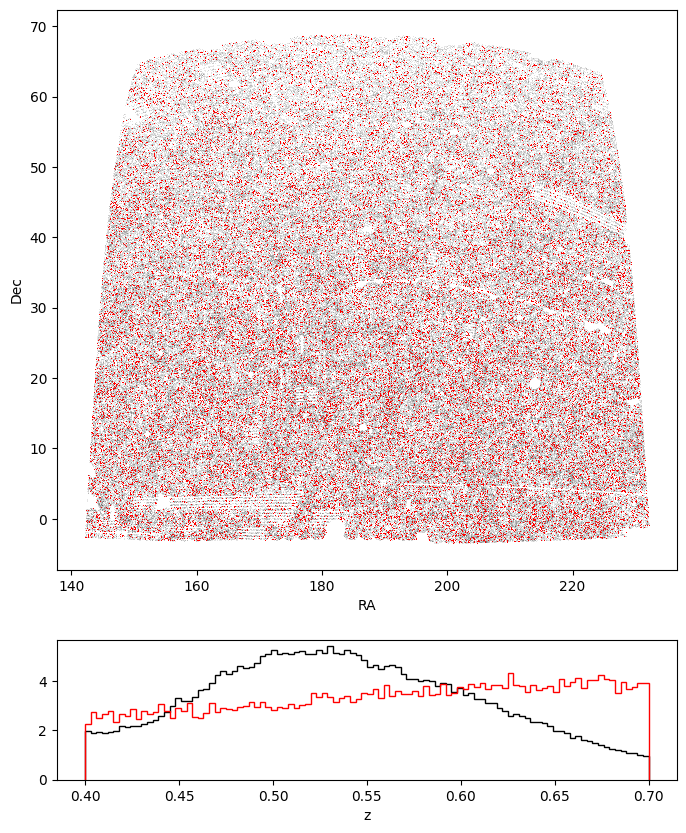

In [22]:
f, axs = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [4, 1]})
axs[0].plot(iiordz[:,0], iiordz[:,1], 'k,', alpha=0.1)
axs[0].plot(mrrdz[:,0], mrrdz[:,1], 'r,', alpha=1)
axs[0].set(xlabel='RA', ylabel='Dec')

axs[1].hist(iiordz[:,2], bins=100, histtype='step', color='k', density=True)
axs[1].hist(mrrdz[:,2], bins=100, histtype='step', color='r', density=True)
axs[1].set(xlabel='z');

## Mass production!

In [33]:
gpos = np.load(join(source_path, 'halo_pos.npy'))
gvel = np.load(join(source_path, 'halo_vel.npy'))

In [34]:
rxyz = gpos
rvel = gvel

# Rotate -dec
ang = -0.03*np.pi
Rz = Rotation.from_rotvec(
    np.array([1, -1, 0])/np.sqrt(2)*ang)
rxyz = Rz.apply(rxyz)
rvel = Rz.apply(rvel)

# Rotate +ra
ang = np.pi*0.79
Rr = Rotation.from_rotvec([0,0,ang])
rxyz = Rr.apply(rxyz)
rvel = Rr.apply(rvel)

# Convert to sky coordinates
rrdz = xyz_to_sky(rxyz, vel=rvel, cosmo=cosmo)

In [35]:
# Apply survey masks to MTNG data
from cmass.survey.tools import BOSS_angular, BOSS_veto, BOSS_redshift

mask = BOSS_angular(ra=rrdz[:,0], dec=rrdz[:,1], wdir=wdir)
mrrdz = rrdz[mask]
mask = BOSS_veto(ra=mrrdz[:,0], dec=mrrdz[:,1], verbose=True, wdir=wdir)
mrrdz = mrrdz[~mask]
mask = BOSS_redshift(z=mrrdz[:,2])
mrrdz = mrrdz[mask]

badfield_mask_postprocess_pixs8.ply
badfield_mask_unphot_seeing_extinction_pixs8_dr12.ply
allsky_bright_star_mask_pix.ply
bright_object_mask_rykoff_pix.ply
centerpost_mask_dr12.ply
collision_priority_mask_dr12.ply


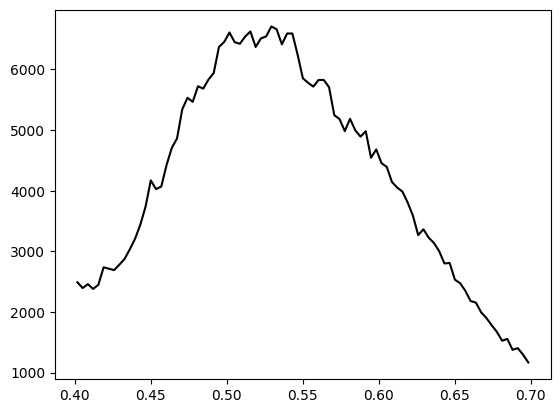

In [36]:
# Get observational n(z)
from astropy.stats import scott_bin_width
_, be = scott_bin_width(iiordz[:,2], return_bins=True)
hobs, be = np.histogram(iiordz[:,2], bins=be)

plt.plot(0.5*(be[1:]+be[:-1]), hobs, 'k-')

In [37]:
from cmass.survey.ngc_selection import reweight
mrrdz = reweight(mrrdz, be=be, hobs=hobs)

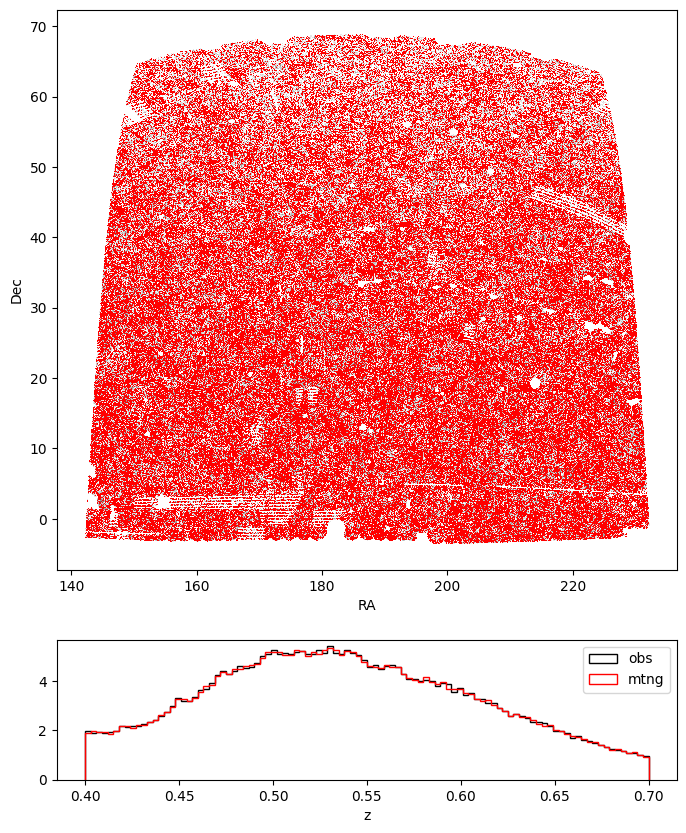

In [44]:
f, axs = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [4, 1]})
axs[0].plot(iiordz[:,0], iiordz[:,1], 'k,', alpha=0.1)
axs[0].plot(mrrdz[:,0], mrrdz[:,1], 'r,', alpha=1)
axs[0].set(xlabel='RA', ylabel='Dec')

axs[1].hist(iiordz[:,2], bins=100, histtype='step', color='k', density=True, label='obs')
axs[1].hist(mrrdz[:,2], bins=100, histtype='step', color='r', density=True, label='mtng')
axs[1].set(xlabel='z')
axs[1].legend();

In [39]:
# Save MTNG lightcone
from cmass.survey.tools import save_lightcone
save_lightcone(join(source_path, 'lightcone'), ra=mrrdz[:,0], dec=mrrdz[:,1], z=mrrdz[:,2])

In [41]:
# Save CMASS lightcone
cmass_path = join(wdir, 'cmass_ngc', 'cmass', 'L0-N0', '0', 'lightcone')
save_lightcone(cmass_path, ra=iiordz[:,0], dec=iiordz[:,1], z=iiordz[:,2], aug_seed=1)

In [50]:
axyz = sky_to_xyz(mrrdz, cosmo=cosmo)
bxyz = sky_to_xyz(iiordz, cosmo=cosmo)

offset = axyz.min(axis=0)
axyz -= offset
bxyz -= offset

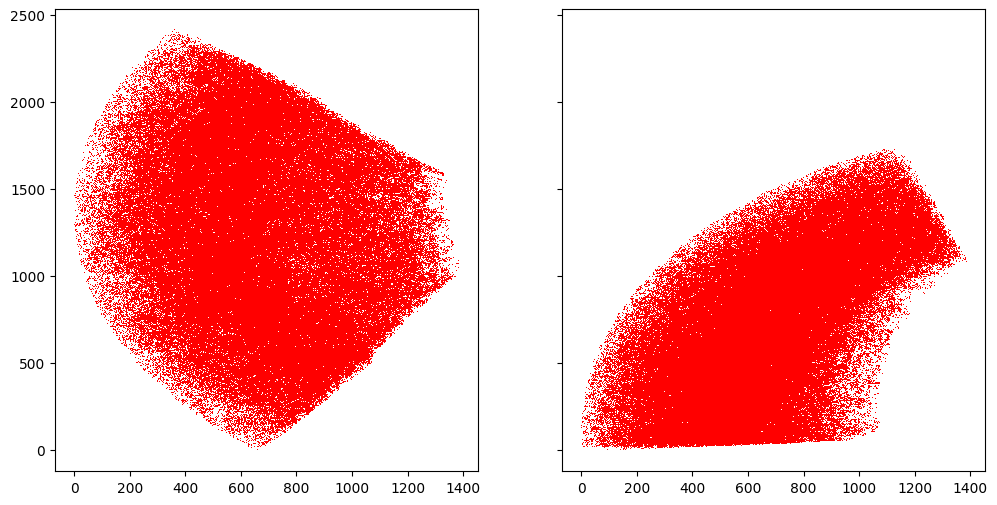

In [52]:
f, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axs[0].plot(axyz[:,0], axyz[:,1], 'r,')
axs[1].plot(axyz[:,0], axyz[:,2], 'r,')

In [54]:
from cmass.diagnostics.tools import MA, calcPk

adelta = MA(axyz.astype(np.float32), L=2500, N=300)
bdelta = MA(bxyz.astype(np.float32), L=2500, N=300)

ak, aPk = calcPk(adelta, L=2500)
bk, bPk = calcPk(bdelta, L=2500)

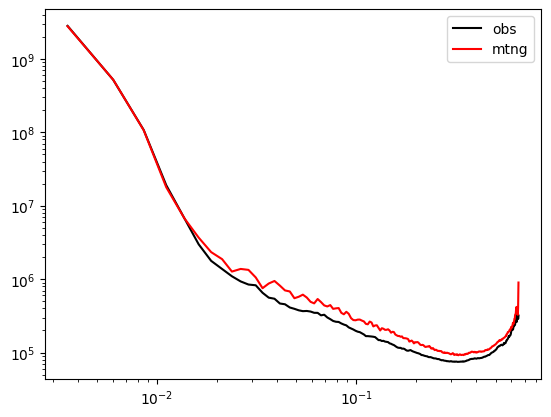

In [58]:

plt.loglog(bk, bPk[...,0], 'k-', label='obs')
plt.loglog(ak, aPk[...,0], 'r-', label='mtng')
plt.legend();